In [17]:
import requests
import numpy as np
import pandas as pd
from IPython.display import display, Image as IPImage
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display
from dotenv import load_dotenv
import os
import joblib

📥 2. Load TMDB Dataset

In [18]:
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [19]:
load_dotenv()  # Load environment variables from .env
API_KEY = os.getenv("TMDB_API_KEY")

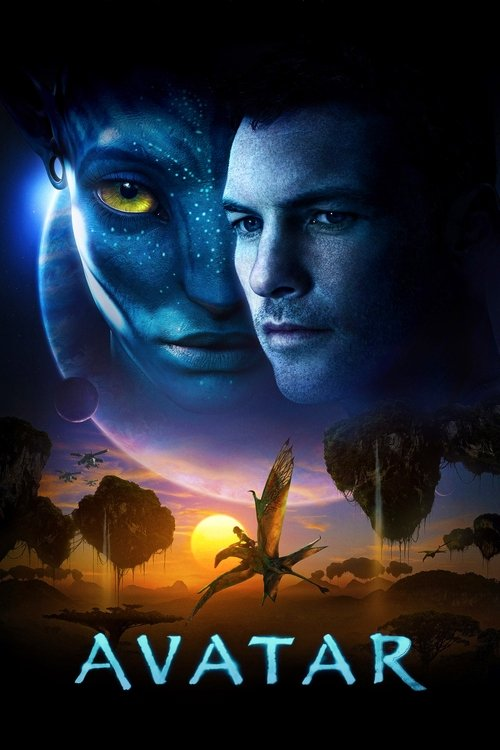

In [20]:
# Fetch poster for a given movie_id from TMDb
def fetch_poster(movie_id):
    try:
        # Make a request to TMDb API to get movie details
        response = requests.get(f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={API_KEY}&language=en-US")
        data = response.json()

        # Check if poster exists
        if 'poster_path' in data and data['poster_path']:
            # Construct the URL for the poster image
            poster_url = f"https://image.tmdb.org/t/p/w500{data['poster_path']}"
            return poster_url
        else:
            print(f"No poster found for movie with ID: {movie_id}")
            return None
    except Exception as e:
        print(f"Error fetching poster for movie ID {movie_id}: {e}")
        return None

# Example usage: Fetch poster for a specific movie (replace with an actual movie ID)
movie_id = 19995  # For example, "Fight Club" (movie ID in TMDb)
poster_url = fetch_poster(movie_id)

# If poster URL is returned, display the image in Colab
if poster_url:
    # Display image using IPython's Image display method
    display(IPImage(poster_url))


🔗 3. Merge Movies + Credits

In [21]:
movies = movies.merge(
    credits,
    left_on="id",
    right_on="movie_id"
)

In [22]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'movie_id', 'title_y', 'cast', 'crew'],
      dtype='object')

🧹 4. Rename Columns

In [23]:
#movies = movies[
#    ["title_x", "overview", "genres", "keywords", "cast", "crew"]
#]

movies.rename(columns={"title_x": "title"}, inplace=True)

🧠 5. Feature Engineering (Critical Netflix Step)

Convert JSON-like strings to text

In [24]:
import ast

def extract_names(text):
    try:
        data = ast.literal_eval(text)
        return " ".join([i["name"] for i in data])
    except:
        return ""

In [25]:
movies["genres"] = movies["genres"].apply(extract_names)
movies["keywords"] = movies["keywords"].apply(extract_names)

def extract_cast_names(text):
    try:
        data = ast.literal_eval(text)
        return " ".join([i.get("name", "") for i in data[:3]])
    except:
        return ""

movies["cast"] = movies["cast"].apply(extract_cast_names)

def extract_director(text):
    try:
        data = ast.literal_eval(text)
        return " ".join([i.get("name", "") for i in data if i.get("job") == "Director"])
    except:
        return ""

movies["crew"] = movies["crew"].apply(extract_director)


 6. Create Netflix-Style “Tags”

In [26]:
movies["tags"] = (
    movies["overview"].fillna("") + " " +
    movies["genres"] + " " +
    movies["keywords"] + " " +
    movies["cast"] + " " +
    movies["crew"]
)

🔢 7. Vectorization (ML Core)

In [27]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english"
)

vectors = vectorizer.fit_transform(movies["tags"])

# Save the similarity matrix directly
joblib.dump(vectors, "vectors.pkl", compress=3)

['vectors.pkl']

📐 8. Cosine Similarity Matrix

In [28]:
#similarity = cosine_similarity(vectors)

similarity = cosine_similarity(vectors).astype("float16")


🎯 9. Netflix-Style Recommendation Function

In [29]:
def recommend(movie_title, top_n=10):
    # Find the index of the movie based on its title
    index = movies[movies["title"] == movie_title].index[0]
    
    # Get the similarity scores for the given movie
    distances = similarity[index]

    # Sort the movies by similarity score, ignoring the input movie itself
    movie_list = sorted(
        list(enumerate(distances)),
        reverse=True,
        key=lambda x: x[1]
    )[1:top_n+1]  # Skip the first element because it's the movie itself

    # Return a list of tuples: (movie_title, movie_id as int)
    return [(fetch_poster(movies.iloc[i[0]].id), movies.iloc[i[0]].title) for i in movie_list]


In [ ]:
recommend("The Dark Knight Rises")

In [ ]:
# Save vectors (sparse matrix)
joblib.dump(movies, "movies.pkl", compress=3)

# Save the similarity matrix directly
#joblib.dump(similarity, "similarity_matrix.pkl", compress=3)


['movies.pkl']